## Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import re
import csv
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,precision_recall_fscore_support

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

# import ipwhois

## Load Data

In [25]:
df_train_benin = pd.read_csv('Data/Train_Benign_Traffic.csv',encoding="latin1")
df_train_mal = pd.read_csv('Data/Train_Detections.csv')
df_test = pd.read_csv('Data/Test_Set_Hackathon.csv')
df_train_ips = pd.read_csv('Data/Train_IPS.csv')
# We built a csv with IP types
df_ips = pd.read_csv('Data/IPTypes.csv').set_index('ip')

# Add Label to train data and merge malware and benign sets
df_train_benin['label'] = 'benign'
df_train = pd.concat([df_train_benin,df_train_mal], sort=False).reset_index()
df_train.head()

,index,Unnamed: 0,app_name,app_risk,client,dst_ip,dst_port,epoch_time,protocol,received_bytes,sent_bytes,src_ip,label
0,0,0,Google Play,Low,2,222.58.210.46,443.0,1547242292,TCP,44096,67712,10.197.88.33,benign
1,1,1,Twitter,Low,5,110.244.46.16,443.0,1547468725,TCP,7712,1990,10.0.11.69,benign
2,2,2,Apple Siri,Low,2,23.130.21.5,443.0,1547415821,TCP,12928,8464,192.168.174.137,benign
3,3,3,Microsoft Account,Very Low,2,71.55.163.78,443.0,1547152973,TCP,19808,4376,192.168.190.183,benign
4,4,4,Unknown Traffic,Unknown,5,230.0.0.1,NaN,1547070189,TCP,0,252,10.0.11.2,benign


In [26]:
# Look at the data structure
df_train.describe(include=['O'])

,app_name,app_risk,dst_ip,epoch_time,protocol,src_ip,label
count,50440,50440,50993,50993,50993,50993,50993
unique,434,6,7541,36312,2,3354,3
top,Web Browsing,Low,230.0.0.251,1547471593,TCP,200.75.192.252,benign
freq,5039,21714,2358,24,44171,1934,50440


## Features Engineering

In [23]:
def split_len(x):
    return len(x.split('.'))

In [27]:
# Remove unused columns
df_train = df_train.drop(['index','Unnamed: 0','app_name','app_risk'],axis=1)

# Make Labels True/False
df_train.label = df_train.label.replace({'benign':False,'Malware':True,'Adware':True})

# Remove the easter eggs (i.e. IP with 5 bytes)
df_train = df_train[df_train.dst_ip.map(split_len) < 5 ].reset_index()
df_train = df_train[df_train.src_ip.map(split_len) < 5 ].reset_index().drop(['index','level_0'],axis=1)

### Internal / External IP Types

In [28]:
# Add Internal / External IP Type
df_train = df_train.join(df_ips,on='src_ip',rsuffix='_src').drop('Unnamed: 0',axis=1)
df_train = df_train.join(df_ips,on='src_ip',rsuffix='_src').drop('Unnamed: 0',axis=1)
df_train = df_train.join(df_ips,on='dst_ip',lsuffix='_dst').drop(['type', 'subtype', 'Unnamed: 0'],axis=1)
df_train.head()

,client,dst_ip,dst_port,epoch_time,protocol,received_bytes,sent_bytes,src_ip,label,type_dst,subtype_dst,type_src,subtype_src
0,2,222.58.210.46,443.0,1547242292,TCP,44096,67712,10.197.88.33,False,Internal,Class A,Internal,Class A
1,5,110.244.46.16,443.0,1547468725,TCP,7712,1990,10.0.11.69,False,Internal,Class A,Internal,Class A
2,2,23.130.21.5,443.0,1547415821,TCP,12928,8464,192.168.174.137,False,Internal,Class C,Internal,Class C
3,2,71.55.163.78,443.0,1547152973,TCP,19808,4376,192.168.190.183,False,Internal,Class C,Internal,Class C
4,5,230.0.0.1,NaN,1547070189,TCP,0,252,10.0.11.2,False,Internal,Class A,Internal,Class A


### Categorize sent_bytes / received_bytes (using Log function) and create total_bytes column

In [29]:
df_train['total_bytes'] = df_train.sent_bytes + df_train.received_bytes
df_train['log_total_bytes'] = np.log1p(df_train.total_bytes).astype(int)
df_train['log_sent_bytes'] = np.log1p(df_train.sent_bytes).astype(int)
df_train['log_received_bytes'] = np.log1p(df_train.received_bytes).astype(int)
df_train.head()

,client,dst_ip,dst_port,epoch_time,protocol,received_bytes,sent_bytes,src_ip,label,type_dst,subtype_dst,type_src,subtype_src,total_bytes,log_total_bytes,log_sent_bytes,log_received_bytes
0,2,222.58.210.46,443.0,1547242292,TCP,44096,67712,10.197.88.33,False,Internal,Class A,Internal,Class A,111808,11,11,10
1,5,110.244.46.16,443.0,1547468725,TCP,7712,1990,10.0.11.69,False,Internal,Class A,Internal,Class A,9702,9,7,8
2,2,23.130.21.5,443.0,1547415821,TCP,12928,8464,192.168.174.137,False,Internal,Class C,Internal,Class C,21392,9,9,9
3,2,71.55.163.78,443.0,1547152973,TCP,19808,4376,192.168.190.183,False,Internal,Class C,Internal,Class C,24184,10,8,9
4,5,230.0.0.1,NaN,1547070189,TCP,0,252,10.0.11.2,False,Internal,Class A,Internal,Class A,252,5,5,0


### Remove Nan from Port and Split IP into bytes

In [33]:
df_train['dst_port'] = df_train.dst_port.fillna(0).astype(int)
df_train =  pd.concat([pd.DataFrame(df_train.dst_ip.apply(lambda x: list(map(int,x.split('.')))).values.tolist(),
             columns=['dst_int_1','dst_int_2','dst_int_3','dst_int_4']),df_train],axis=1)
df_train =  pd.concat([pd.DataFrame(df_train.src_ip.apply(lambda x: list(map(int,x.split('.')))).values.tolist(),
             columns=['src_int_1','src_int_2','src_int_3','src_int_4']),df_train],axis=1)
df_train.head()

,src_int_1,src_int_2,src_int_3,src_int_4,dst_int_1,dst_int_2,dst_int_3,dst_int_4,src_int_1,src_int_2,...,src_ip,label,type_dst,subtype_dst,type_src,subtype_src,total_bytes,log_total_bytes,log_sent_bytes,log_received_bytes
0,10,197,88,33,222,58,210,46,10,197,...,10.197.88.33,False,Internal,Class A,Internal,Class A,111808,11,11,10
1,10,0,11,69,110,244,46,16,10,0,...,10.0.11.69,False,Internal,Class A,Internal,Class A,9702,9,7,8
2,192,168,174,137,23,130,21,5,192,168,...,192.168.174.137,False,Internal,Class C,Internal,Class C,21392,9,9,9
3,192,168,190,183,71,55,163,78,192,168,...,192.168.190.183,False,Internal,Class C,Internal,Class C,24184,10,8,9
4,10,0,11,2,230,0,0,1,10,0,...,10.0.11.2,False,Internal,Class A,Internal,Class A,252,5,5,0


In [35]:
suspicious_ips = df_train[(df_train['label'] == True)].dst_ip
df_train_benign = df_train[df_train['label'] == False]
suspicious_ips = suspicious_ips[~suspicious_ips.isin(df_train_benign.dst_ip)]
suspicious_ips[suspicious_ips != '8.8.8.8'].shape

(127,)

In [36]:
def plot_count(series):
    counts = series.value_counts()
    plt.figure(figsize=(5,2))
    sns.barplot(counts.index,counts)

In [37]:
def plot_pca(df):
    pca = PCA(n_components=2)
    to_pca = df.drop(['dst_ip','src_ip'],axis=1)
    to_pca = to_pca.dropna()
    labels_pca = to_pca.label
    proj = pca.fit_transform(to_pca.drop(['label'],axis=1))
    plt.figure(figsize=(10,6))
    sns.scatterplot(proj[:,0],proj[:,1],hue=labels_pca)

In [42]:
#dummies 
df_train = pd.concat([df_train,pd.get_dummies(df_train.dst_port,prefix='port')],axis=1)

In [43]:
#separate df for client

df_1 = df_train[df_train.client == 1].drop('client',axis=1)
df_2 = df_train[df_train.client == 2].drop('client',axis=1)
df_3 = df_train[df_train.client == 3].drop('client',axis=1)
df_4 = df_train[df_train.client == 4].drop('client',axis=1)
df_5 = df_train[df_train.client == 5].drop('client',axis=1)

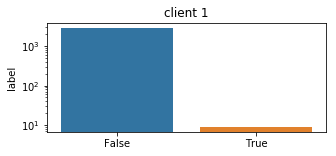

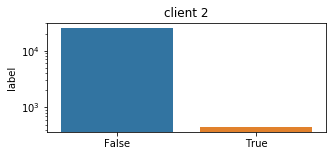

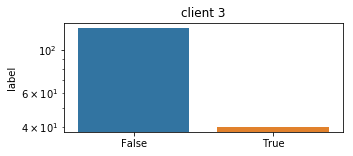

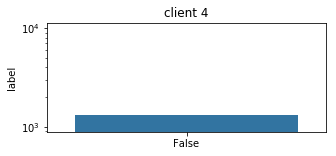

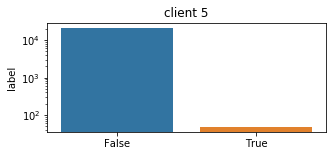

In [44]:
list_of_df = [df_1,df_2,df_3,df_4,df_5]

for i,df in enumerate(list_of_df):
    plot_count(df.label)
    plt.title(f'client {i+1}')
    plt.yscale('log')
    plt.show()

In [46]:
for i, df in enumerate(list_of_df):
    plot_pca(df)
    plt.title(f'client {i+1}')
    plt.show()

ValueError: could not convert string to float: 'TCP'

In [47]:
src_dest = df_train[df_train.label == 'Malware'].apply(lambda x: x.src_ip+'_'+x.dst_ip, axis=1)
test_src_dest = df_test.apply(lambda x: x.src_ip+'_'+x.dst_ip, axis=1)

/Users/jeremybensoussan/anaconda3/envs/ITC/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [49]:
# preds = df_test.apply(lambda x: True if x.dst_ip in suspicious_ips.to_list()
#                       and x.sent_bytes != 1282
#                       and x.received_bytes != 4176
#                       and x.received_bytes != 2002944
#                       else False, axis=1).astype(bool)

def rule_based(df):
    pred_1 = df.apply(lambda x: True 
                          if 
                          x.dst_ip in ['10.200.105.200', '10.200.105.201', '10.200.105.202']
                          and x.dst_port == 53
                          and (x.received_bytes > 0 or x.sent_bytes > 0)
                          and x.received_bytes < 200
                          else False, axis=1).astype(bool)

    pred_2 = df.apply(lambda x: True 
                          if 
                          x.dst_port == 53
                          and x.received_bytes == 0 
                          and x.sent_bytes == 0
                          else False, axis=1).astype(bool)

    pred_3 = df.apply(lambda x: True 
                          if 
                          x.dst_ip == '8.8.8.8'
                          and x.protocol == 'UDP'
                          else False, axis=1).astype(bool)

    pred_4 = df.apply(lambda x: True if x.dst_ip in suspicious_ips.to_list()
                          and x.sent_bytes != 1282
                           and x.client == 2
                           and x.dst_port == 80
                          else False, axis=1).astype(bool)

    pred_5 = df.apply(lambda x: True if 
                           x.dst_port == 53
                           and x.dst_ip == '10.200.105.201'
                           and x.received_bytes <= 540
                          else False, axis=1).astype(bool)
    
    pred_6 = df.apply(lambda x: True if 
                           x.dst_port == 53
                           and x.dst_ip == '70.115.0.9'
                           and x.received_bytes == 0
                          else False, axis=1).astype(bool)
    
    pred_7 = df.apply(lambda x: True if 
                       x.dst_port == 53
                       and x.dst_ip == '10.200.105.202'
                       and x.received_bytes > 10
                      else False, axis=1).astype(bool)
    
    test_src_dest = df_test.apply(lambda x: x.src_ip+'_'+x.dst_ip, axis=1)
    pred_8 = test_src_dest.isin(src_dest)
        
#     return pred_1 | pred_2 | pred_3 | pred_4 | pred_5 | pred_6 | pred_7 | pred_8
    return pred_1 | pred_2 | pred_3 | pred_4 | pred_5
    
preds = rule_based(df_test)
df_test[preds].shape
df_test[preds].to_csv('predictions.csv')

In [16]:
preds = {v:bool(k) == True for v,k in dict(preds).items()}

In [22]:
r = requests.post('http://192.168.1.24:30000/submission',
                   json={ 'team':'DeepZuchinis',
                          'password':'4lbertKmus',
                          'submission': preds
                         },
                   verify=False)
r.text

KeyboardInterrupt: 

In [141]:
df_train_after_rule_based = df_train[~rule_based(df_train)]
df_train_after_rule_based.shape

(50482, 213)

In [142]:
print(df_train_after_rule_based[df_train_after_rule_based.label != 'benign'].dst_port.value_counts())
df_train_after_rule_based = df_train_after_rule_based[df_train_after_rule_based.dst_port == 80]

80       38
53       13
29080     3
8040      2
9100      1
8899      1
Name: dst_port, dtype: int64


In [136]:
df_remaining_malicious = df_train_after_rule_based[df_train_after_rule_based['label'] != 'benign']
df_remaining_malicious.describe(include=['O'])

,dst_ip,epoch_time,label,protocol,src_ip,type_dst,subtype_dst,type_src,subtype_src
count,38,38,38,38,38,38,38,38,38
unique,15,37,1,1,18,2,3,2,3
top,192.168.98.222,1546547144,Malware,TCP,192.168.37.10,Internal,Class C,Internal,Class C
freq,16,2,38,38,16,30,21,30,21


In [137]:
# Encode the data before fitting the models
from collections import defaultdict
d = defaultdict(LabelEncoder)

# Encoding the variable
df_enc = df_train_after_rule_based.drop(['epoch_time'], axis=1).apply(lambda x: d[x.name].fit_transform(x))
df_enc.head()

,src_int_1,src_int_2,src_int_3,src_int_4,dst_int_1,dst_int_2,dst_int_3,dst_int_4,client,dst_ip,...,port_60802,port_60811,port_60842,port_60851,port_60868,port_61111,port_62139,port_64643,port_64726,port_65476
5,0,50,43,29,7,106,4,52,1,1096,...,0,0,0,0,0,0,0,0,0,0
8,0,0,1,66,42,21,91,29,4,3743,...,0,0,0,0,0,0,0,0,0,0
9,0,0,1,61,17,235,186,86,4,2437,...,0,0,0,0,0,0,0,0,0,0
10,0,0,1,119,14,3,13,114,4,2036,...,0,0,0,0,0,0,0,0,0,0
12,0,0,1,169,97,100,250,2,4,732,...,0,0,0,0,0,0,0,0,0,0


In [138]:
X = df_enc.drop(['label'], axis=1)
y = df_enc['label']

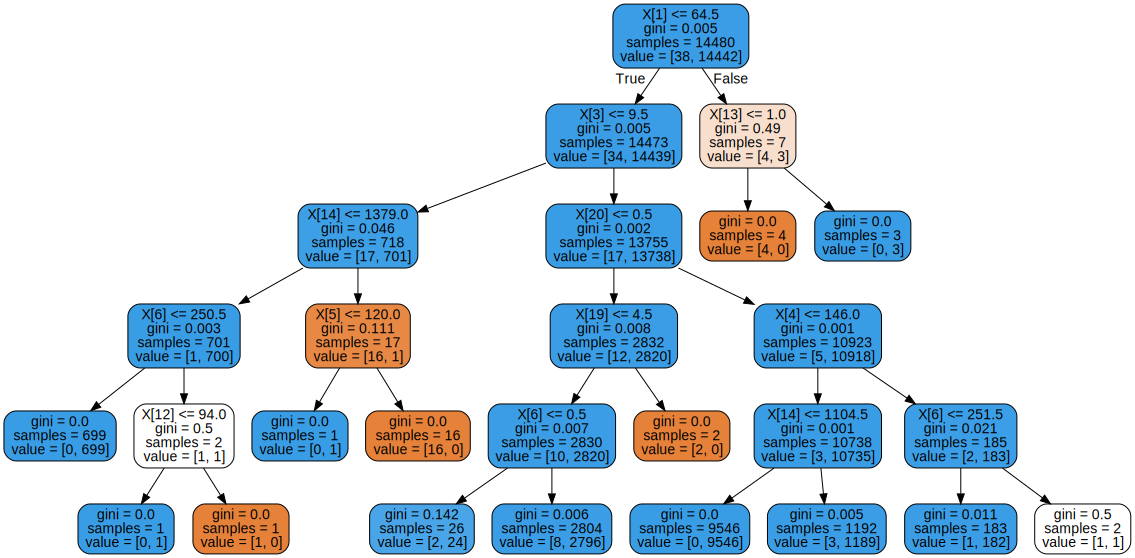

In [146]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X, y)

graph = Source(export_graphviz(clf, out_file=None,filled=True, rounded=True))
display(SVG(graph.pipe(format='svg')))

In [150]:
X['label'] = y
X_decoded = X.apply(lambda x: d[x.name].inverse_transform(x))
X_decoded.shape

(14480, 212)

In [171]:
X.columns[2]

'src_int_3'

In [185]:
X_decoded[(X.src_int_2 <= 64) &
          (X.src_int_4 <= 9) &
          (X.src_ip > 1379) &
          (X.src_int_3 <= 33)].iloc[0]

src_int_1                        192
src_int_2                        168
src_int_3                         37
src_int_4                         10
dst_int_1                        192
dst_int_2                        168
dst_int_3                         98
dst_int_4                        222
client                             3
dst_ip                192.168.98.222
dst_port                          80
protocol                         TCP
received_bytes                     0
sent_bytes                         0
src_ip                 192.168.37.10
type_dst                    Internal
subtype_dst                  Class C
type_src                    Internal
subtype_src                  Class C
log_sent_bytes                     0
log_received_bytes                 0
port_0                             0
port_21                            0
port_22                            0
port_23                            0
port_25                            0
port_37                            0
p

In [189]:
df_test[df_test.dst_port == 80]

,Unnamed: 0,client,dst_ip,dst_port,protocol,received_bytes,sent_bytes,src_ip
4,4,5,44.67.14.232,80.0,TCP,92,132,10.0.11.94
6,6,1,179.198.245.125,80.0,TCP,0,0,200.75.192.252
7,7,5,58.204.250.175,80.0,TCP,0,0,10.0.11.122
8,8,5,78.167.239.239,80.0,TCP,10432,2752,10.0.11.142
10,10,2,205.187.193.130,80.0,TCP,0,0,10.196.74.10
17,17,5,29.196.67.12,80.0,TCP,0,0,10.0.11.94
21,21,2,99.184.220.29,80.0,TCP,2148,1194,192.168.146.118
22,22,5,29.211.101.56,80.0,TCP,13520,3468,10.0.11.76
24,24,5,19.107.4.50,80.0,TCP,14467072,1343488,10.0.11.66
25,25,5,29.3.13.145,80.0,TCP,0,0,10.0.11.82


In [192]:
src_dest = X_decoded[X_decoded.label == 'Malware'].apply(lambda x: x.src_ip+'_'+x.dst_ip, axis=1)

In [194]:
test_src_dest = df_test.apply(lambda x: x.src_ip+'_'+x.dst_ip, axis=1)

In [195]:
df_test[test_src_dest.isin(src_dest)]

,Unnamed: 0,client,dst_ip,dst_port,protocol,received_bytes,sent_bytes,src_ip
1085,1085,1,200.75.192.250,80.0,TCP,0,0,72.240.205.34
3358,3358,5,214.88.55.205,80.0,TCP,4176,1256,10.0.11.112
4167,4167,5,24.215.90.210,80.0,TCP,0,0,10.0.11.152
7166,7166,1,29.198.85.182,80.0,TCP,112328704,1650688,200.75.192.252
